 Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Style
plt.style.use("dark_background")
sns.set_palette("husl")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.2f}".format)

DATA_DIR = Path(".")
LOG_FILE = DATA_DIR / "synthetic_logs.csv"
GT_FILE  = DATA_DIR / "ground_truth.csv"

print("Ready.")

Ready.


 Load Data

In [2]:
logs = pd.read_csv(LOG_FILE, parse_dates=["timestamp"])
gt   = pd.read_csv(GT_FILE,  parse_dates=["timestamp"])

print(f"Log entries     : {len(logs):,}")
print(f"Anomalous entries: {len(gt):,}")
print(f"Date range      : {logs.timestamp.min().date()} → {logs.timestamp.max().date()}")
print(f"Columns         : {list(logs.columns)}")

Log entries     : 33,440
Anomalous entries: 5,994
Date range      : 2026-02-12 → 2026-02-25
Columns         : ['timestamp', 'username', 'department', 'src_ip', 'dst_ip', 'protocol', 'http_method', 'url', 'status_code', 'bytes_sent', 'bytes_received', 'action', 'url_category', 'threat_category', 'risk_score', 'user_agent']


/tmp/ipykernel_2908/1532818681.py:1: DtypeWarning: Columns (0: threat_category) have mixed types. Specify dtype option on import or set low_memory=False.
  logs = pd.read_csv(LOG_FILE, parse_dates=["timestamp"])


 Company Overview

In [3]:
print("=== Users ===")
print(logs.groupby(["username", "department"])["timestamp"].count()
      .rename("request_count")
      .sort_values(ascending=False)
      .to_string())

=== Users ===
username                   department 
jennifermiles@company.com  Engineering    7612
johnsonjoshua@company.com  Engineering    4870
susanrogers@company.com    Engineering    3515
michellejames@company.com  Engineering    3395
arnoldmaria@company.com    Engineering    3387
cassandra07@company.com    Finance        2843
blakeerik@company.com      Finance        2311
janetwilliams@company.com  Finance        2054
garzaanthony@company.com   Finance        1735
mitchellclark@company.com  Finance        1718


Requests Per Day

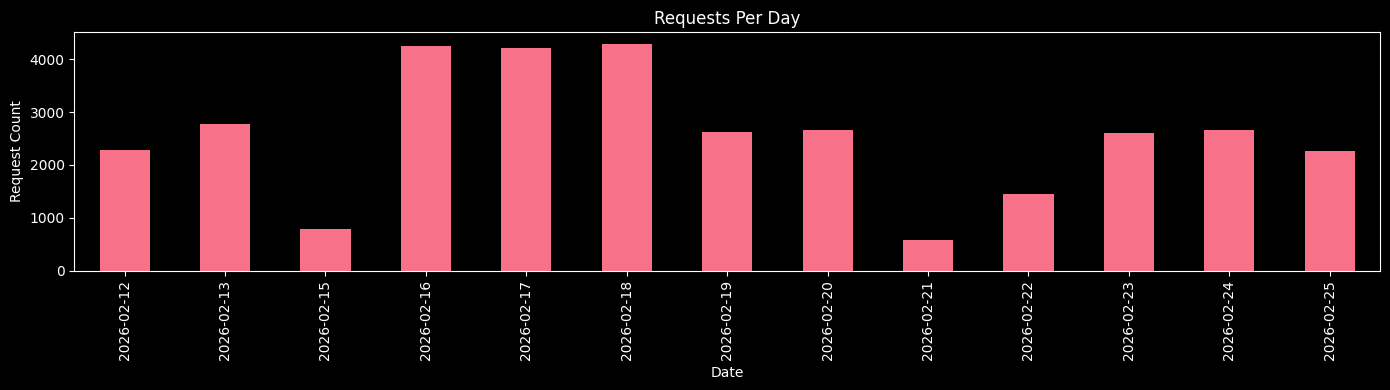

In [4]:
logs["date"] = logs.timestamp.dt.date

daily = logs.groupby("date").size().rename("requests")

daily.plot(kind="bar", figsize=(14, 4), title="Requests Per Day")
plt.xlabel("Date")
plt.ylabel("Request Count")
plt.tight_layout()
plt.show()

 Top Domains

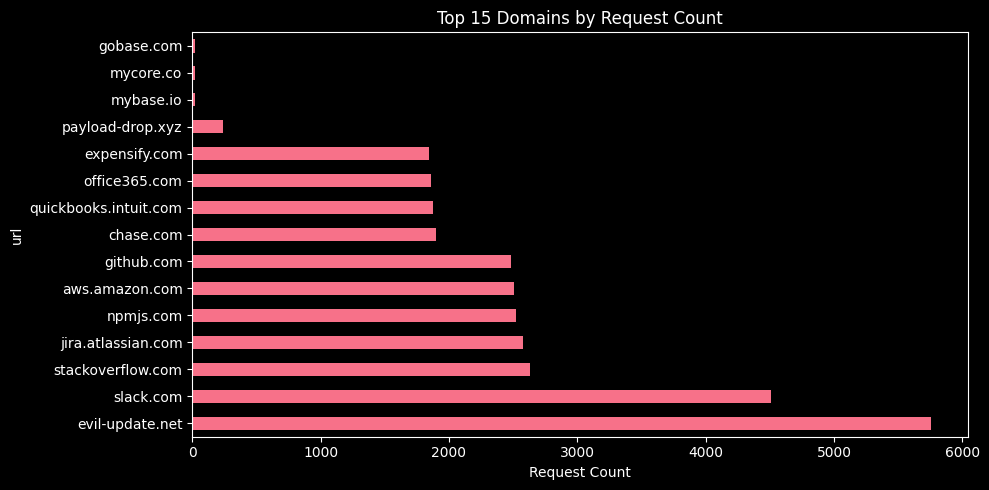

In [7]:
domain = logs.url.str.split("/").str[0]

top = domain.value_counts().head(15)
top.plot(kind="barh", figsize=(10, 5), title="Top 15 Domains by Request Count")
plt.xlabel("Request Count")
plt.tight_layout()
plt.show()

Normal vs Anomalous Traffic

is_anomaly
Normal     27389
Anomaly     6051

Anomaly rate: 18.1%


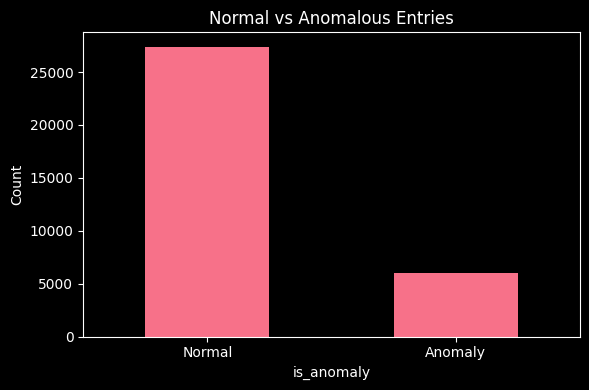

In [9]:
logs["is_anomaly"] = logs.timestamp.isin(gt.timestamp) & \
                     logs.src_ip.isin(gt.src_ip)

counts = logs.is_anomaly.value_counts().rename({False: "Normal", True: "Anomaly"})
print(counts.to_string())
print(f"\nAnomaly rate: {counts['Anomaly'] / len(logs) * 100:.1f}%")

counts.plot(kind="bar", figsize=(6, 4), title="Normal vs Anomalous Entries", rot=0)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

 Ground Truth Breakdown

In [10]:
print("=== Anomaly Types ===")
print(gt.groupby("anomaly_type")["src_ip"].nunique()
      .rename("unique_ips").to_string())

print("\n=== Beacon Users ===")
print(gt[["username", "anomaly_type", "src_ip"]]
      .drop_duplicates()
      .to_string(index=False))

=== Anomaly Types ===
anomaly_type
beaconing_fast       1
beaconing_obvious    1
beaconing_subtle     1

=== Beacon Users ===
                 username      anomaly_type         src_ip
johnsonjoshua@company.com beaconing_obvious   10.52.122.63
jennifermiles@company.com    beaconing_fast 172.24.230.240
 garzaanthony@company.com  beaconing_subtle   10.13.150.31


 Beacon Timing

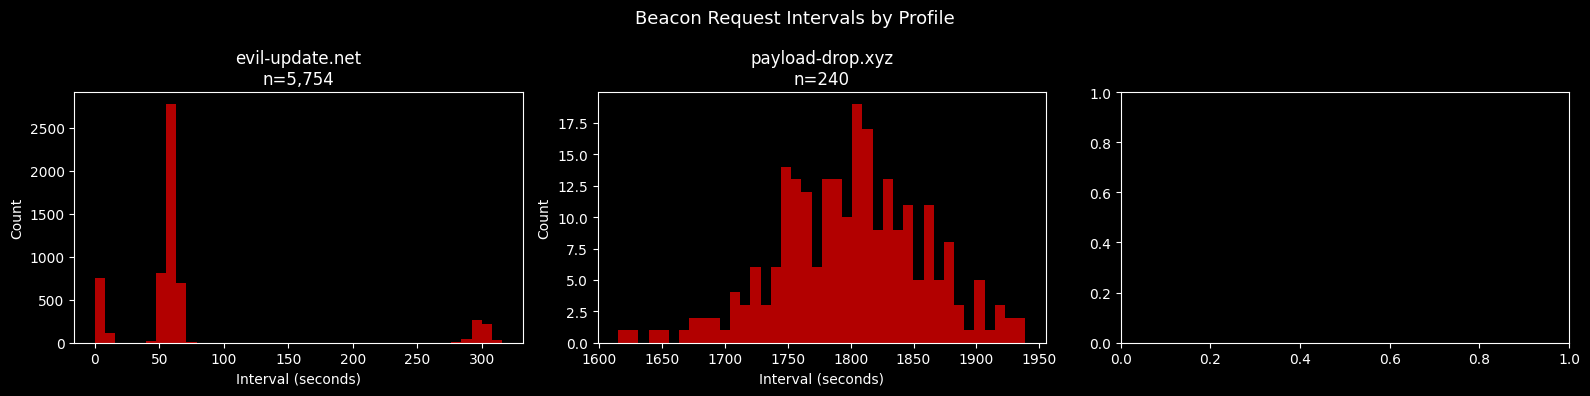

In [11]:
# Pull beacon traffic only
beacon_ips = gt.src_ip.unique()
beacon_domains = gt.url.str.split("/").str[0].unique()

beacon_logs = logs[
    logs.src_ip.isin(beacon_ips) &
    logs.url.str.split("/").str[0].isin(beacon_domains)
].copy()

beacon_logs["domain"] = beacon_logs.url.str.split("/").str[0]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Beacon Request Intervals by Profile", fontsize=13)

for ax, (name, group) in zip(axes, beacon_logs.groupby("domain")):
    intervals = group.timestamp.sort_values().diff().dt.total_seconds().dropna()
    intervals = intervals[intervals < 4000]
    ax.hist(intervals, bins=40, color="red", alpha=0.7)
    ax.set_title(f"{name}\nn={len(group):,}")
    ax.set_xlabel("Interval (seconds)")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

 Normal Traffic Intervals

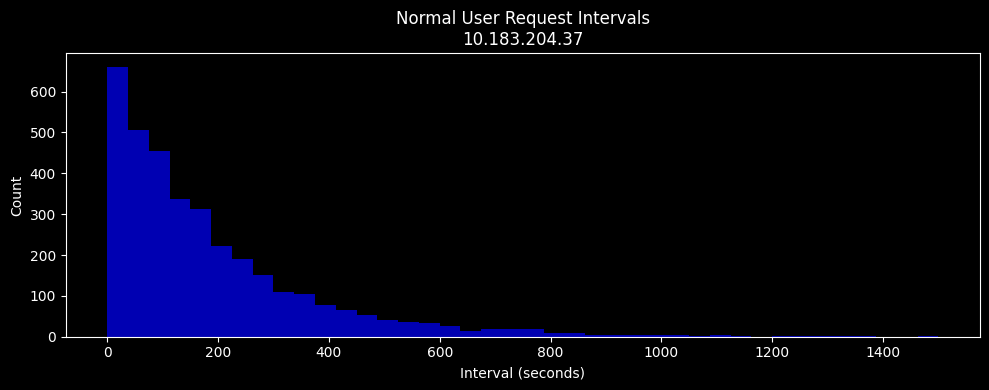

Normal user CV : 1.02
Expected beacon CV: ~0.01-0.07


In [12]:
# Sample a normal user
normal_user = logs[~logs.src_ip.isin(beacon_ips)].groupby("src_ip").size().idxmax()
normal_logs = logs[logs.src_ip == normal_user].sort_values("timestamp")

intervals = normal_logs.timestamp.diff().dt.total_seconds().dropna()
intervals = intervals[intervals < 20000]

plt.figure(figsize=(10, 4))
plt.hist(intervals, bins=40, color="blue", alpha=0.7)
plt.title(f"Normal User Request Intervals\n{normal_user}")
plt.xlabel("Interval (seconds)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Normal user CV : {intervals.std() / intervals.mean():.2f}")
print(f"Expected beacon CV: ~0.01-0.07")

 Feature Vector Contrast

In [13]:
import sys
sys.path.append("../backend/src")

from socrates.services.parser import parse_log_file
from socrates.ml.feature_engineering import extract_features

all_logs = parse_log_file(str(LOG_FILE))
vectors  = extract_features(all_logs)

BEACON_DOMAINS = {"evil-update.net", "botnet-cmd.cn", "malware-c2.ru", "payload-drop.xyz", "c2-handler.io"}

rows = []
for v in vectors:
    rows.append({
        "type":               "beacon" if v.domain in BEACON_DOMAINS else "normal",
        "domain":             v.domain,
        "avg_interval_s":     v.avg_interval_s,
        "cv":                 v.cv,
        "bytes_sent_cv":      v.bytes_sent_cv,
        "unique_paths_ratio": v.unique_paths_ratio,
        "night_ratio":        v.night_ratio,
        "request_count":      v.request_count,
    })

features_df = pd.DataFrame(rows)

# Summary table
print(features_df.groupby("type")[
    ["cv", "bytes_sent_cv", "unique_paths_ratio", "night_ratio"]
].agg(["mean", "min", "max"]).round(3).to_string())

[parser] 33,440 / 33,440 rows parsed in 475ms
[feature_engineering] Extracted 58 feature vectors
         cv           bytes_sent_cv           unique_paths_ratio           night_ratio          
       mean  min  max          mean  min  max               mean  min  max        mean  min  max
type                                                                                            
beacon 0.04 0.02 0.07          0.06 0.06 0.06               0.00 0.00 0.00        0.50 0.50 0.50
normal 4.66 3.82 6.19          0.27 0.22 0.30               0.02 0.02 0.04        0.15 0.09 0.20


 Feature Distribution Plot

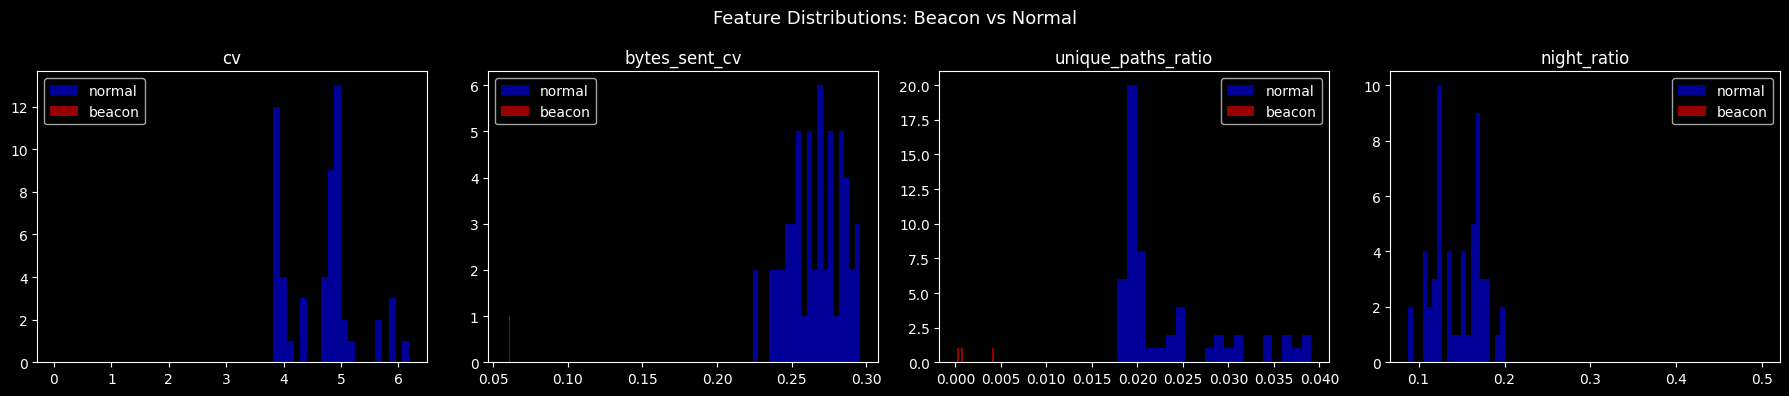

In [14]:
features = ["cv", "bytes_sent_cv", "unique_paths_ratio", "night_ratio"]
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.suptitle("Feature Distributions: Beacon vs Normal", fontsize=13)

for ax, feat in zip(axes, features):
    for ftype, color in [("normal", "blue"), ("beacon", "red")]:
        subset = features_df[features_df.type == ftype][feat]
        ax.hist(subset, bins=20, alpha=0.6, color=color, label=ftype)
    ax.set_title(feat)
    ax.legend()

plt.tight_layout()
plt.show()